# Ordenando un patio de maniobras 

## Descripción

¡Felicidades! Eres el nuevo gerente de una patio de maniobras muy soleada, ideal para la eficiencia energética de tus equipos. Te han asignado cinco robots innovadores para ayudarte a organizar el espacio. El patio está en completo desorden debido al gerente anterior, así que tu tarea es coordinar a los robots para organizar las cajas y hacer que el patio de labores funcione de manera eficiente.

Cada robot tiene ruedas omnidireccionales, lo que les permite moverse en las cuatro direcciones. Además, pueden recoger cajas en celdas adyacentes y transportarlas a cualquier otra ubicación, incluso apilándolas en torres de hasta cinco cajas. Los robots están equipados con sensores avanzados que les permiten detectar lo que hay en las cuatro celdas alrededor de ellos: puede ser una celda vacía, una pared, una pila de cajas (y cuántas cajas contiene) o incluso otro robot. También saben cuándo están llevando una caja gracias a sus sensores de presión.

Cada robot consume una unidad de energía por cada celda que se desplaza. Inicialmente, cada robot dispone de 200 unidades de energía, permitiéndoles moverse una cantidad razonable antes de requerir recarga. Además, los robots están equipados con celdas fotovoltaicas para aprovechar la abundante luz solar en este espacio abierto. Cuando un robot necesita recargarse, debe permanecer inactivo durante 10 pasos de simulación para completar el proceso de recarga.

Tu misión es desarrollar una estrategia para organizar todas las cajas en pilas de exactamente cinco unidades cada una. Debes minimizar la distancia total recorrida por los robots, reducir el tiempo total de recarga y disminuir la cantidad de recargas necesarias para cada robot.

## Requerimientos

- El patio de maniobras tiene un tamaño de 20 x 20 celdas.
- Comienza con 100 cajas distribuidas aleatoriamente en el suelo del patio, sin pilas.
- Los robots empiezan en posiciones vacías y aleatorias.
- La simulación termina cuando todas las cajas están apiladas en columnas de cinco cajas.
- Desarrolla dos soluciones distintas: la primera sin coordinación, basada en movimientos aleatorios de los robots, y la segunda con una estrategia coordinada. La estrategia coordinada debe buscar minimizar la distancia total recorrida por los robots, reducir el tiempo total de recarga y disminuir la cantidad de recargas necesarias para cada robot.
- Debes crear una visualización tanto para la solución sin coordinación como para la solución con la estrategia coordinada.

## Especificaciones de entrega

- Deberás presentar un informe en formato PDF que describa detalladamente los mecanismos de coordinación utilizados, las estructuras de datos y los algoritmos empleados, junto con la justificación para cada elección. Además, utilizando gráficas y datos obtenidos de tus simulaciones, argumenta si la solución coordinada ha conseguido una mejora significativa. Si no es así, indica posibles cambios que podrías implementar para lograr esa mejora. Ten en cuenta que el informe debe tener una extensión mínima de una página y que los resultados basados en menos de 10 simulaciones no se considerarán fiables.

- El cuaderno Jupyter que contiene tu implementación en Python.



# Instalación e importación de librerías

In [40]:
# Descargar mesa y seaborn
%pip install mesa==2.3.1 seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [41]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con 'RandomActivation' podemos activar los agentes en un orden aleatorio.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# BATCH_RUNNER
from mesa.batchrunner import batch_run

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

# Importamos el paquete seaborn para mejorar la visualización de los datos.
import seaborn as sns

# Solución estratégica

El enfoque de esta solución consiste en las siguientes reglas.

- Los robots se mueven aleatoriamente para buscar paquetes.
- Los robots al iniciar su primera pila, guardan su ubicación y la comparten.
- Cuando un robot encuentra un paquete, lo lleva a la pila más cercana.
- Los robots compartirán un registro de las celdas visitadas para no buscar dónde ya se sabe que no hay paquetes

In [42]:
# Helpers

def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for content, (x, y) in model.grid.coord_iter():
        grid[x][y] = model.cells[x][y]
        if content != None:
            grid[x][y] = 10
    return grid

def get_distance(x1, y1, x2, y2):
    return abs(x1 - x2) + abs(y1 - y2)

In [ ]:
class RobotAgent(Agent):
    """
    Clase que define al agente robot que ordenará los paquetes.
    """

    def __init__(self, id, model, max_energy):
        """
        Inicializa el agente robot.

        Args:
            id: Identificador único del agente.
            model: Modelo en el que se encuentra el agente.
            max_energy: Energía máxima del agente.
        """

        # Inicializa la clase padre.
        super().__init__(id, model)

        # Inicializa los atributos del agente (False = No está cargando, True = Está cargando).
        self.package = False

        # Energía
        self.energy = max_energy
        self.steps_to_recharge = 10
        self.recharge = 0

        # Stack de celdas visitadas (backtracking).
        self.backtracking = []

    def reset_visited(self):
        """
        Resetea el estado de las celdas visitadas cuando sea necesario
        (por ejemplo, cuando no se encuentran más paquetes en el área explorada)
        """
        for x in range(self.model.grid.width):
            for y in range(self.model.grid.height):
                if (x, y) not in self.model.stacks:
                    self.model.visited[x][y] = 0

    def search_package(self):
        """
        Mueve al agente robot a una celda adyacente para buscar un paquete.
        Implementa backtracking cuando no encuentra caminos válidos.
        """
        # Stack para guardar las celdas vacías
        empty_cells = []

        # Obtiene las celdas adyacentes
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, 
            moore=False, 
            include_center=False
        )

        # Obtener índices del arreglo de posiciones posibles y desordenarlos
        indexes = [x for x in range(len(possible_steps))]
        np.random.shuffle(indexes)

        # Busca un paquete en las celdas adyacentes
        for i in indexes:
            # Obtiene las coordenadas de la celda
            (x, y) = possible_steps[i]

            # Verifica si la celda es válida y no visitada
            if self.model.grid.is_cell_empty((x, y)) and self.model.visited[x][y] == 0:
                # ¿Hay un paquete en la celda?
                if self.model.grid[x][y] == 1:
                    # Guarda la posición actual para backtracking
                    self.backtracking.append(self.pos)
                    
                    # Marca la celda como visitada (si no es una pila)
                    if (x, y) not in self.model.stacks:
                        self.model.visited[x][y] = 1

                    # Mueve al agente a la celda
                    self.model.grid.move_agent(self, (x, y))
                    self.energy -= 1
                    return True

                # Guarda la celda vacía como opción
                empty_cells.append((x, y))

        # Si no encontró paquete, intenta moverse a una celda vacía no visitada
        if empty_cells:
            for cell in empty_cells:
                if self.model.grid.is_cell_empty(cell):
                    next_pos = empty_cells.pop()
                    self.backtracking.append(self.pos)
                    self.model.visited[next_pos[0]][next_pos[1]] = 1
                    self.model.grid.move_agent(self, next_pos)
                    self.energy -= 1
                    return True

        # Si no hay movimientos válidos, hacer backtracking
        if self.backtracking:
            prev_pos = self.backtracking[-1]
            if self.model.grid.is_cell_empty(prev_pos):
                self.model.grid.move_agent(self, prev_pos)
                self.backtracking.pop()
                self.energy -= 1
                return True

        return False

    def search_package(self):
        """
        Mueve al agente robot a una celda adyacente para buscar un paquete.
        Implementa backtracking cuando no encuentra caminos válidos.
        """
        # Stack para guardar las celdas vacías
        empty_cells = []

        # Obtiene las celdas adyacentes
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, 
            moore=False, 
            include_center=False
        )

        # Obtener índices del arreglo de posiciones posibles y desordenarlos
        indexes = [x for x in range(len(possible_steps))]
        np.random.shuffle(indexes)

        # Busca un paquete en las celdas adyacentes
        for i in indexes:
            # Obtiene las coordenadas de la celda
            (x, y) = possible_steps[i]

            # Verifica si la celda es válida y no visitada
            if self.model.grid.is_cell_empty((x, y)) and self.model.visited[x][y] == 0:
                # ¿Hay un paquete en la celda?
                if self.model.grid[x][y] == 1:
                    # Guarda la posición actual para backtracking
                    self.backtracking.append(self.pos)
                    
                    # Marca la celda como visitada (si no es una pila)
                    if (x, y) not in self.model.stacks:
                        self.model.visited[x][y] = 1

                    # Mueve al agente a la celda
                    self.model.grid.move_agent(self, (x, y))
                    self.energy -= 1
                    return True

                # Guarda la celda vacía como opción
                empty_cells.append((x, y))

        # Si no encontró paquete, intenta moverse a una celda vacía no visitada
        if empty_cells:
            next_pos = empty_cells.pop()
            self.backtracking.append(self.pos)
            self.model.visited[next_pos[0]][next_pos[1]] = 1
            self.model.grid.move_agent(self, next_pos)
            self.energy -= 1
            return True

        # Si no hay movimientos válidos, hacer backtracking
        if self.backtracking:
            prev_pos = self.backtracking.pop()
            if self.model.grid.is_cell_empty(prev_pos):
                self.model.grid.move_agent(self, prev_pos)
                self.energy -= 1
                return True

        return False

    def search_stack(self):
        """
        Mueve al agente robot a una celda adyacente para buscar una pila.
        """

        # Obtener la posición actual del agente.
        x, y = self.pos

        # Obtener pila más cercana
        closest_stack = None
        for stack in self.model.stacks:
            if closest_stack is None:
                closest_stack = stack
            else:
                x1, y1 = closest_stack
                x2, y2 = stack
                if get_distance(x, y, x1, y1) > get_distance(x, y, x2, y2):
                    closest_stack = stack

        # Calcular la dirección en la que se moverá el agente
        dx = abs(closest_stack[0] - x)
        dy = abs(closest_stack[1] - y)

        # Determinar siguiente posición
        if dx >= dy:
            # Moverse en X
            next_x = x + (1 if closest_stack[0] > x else -1)
            next_y = y
        else:
            # Moverse en Y
            next_x = x
            next_y = y + (1 if closest_stack[1] > y else -1)

        # Verificar si la celda a la que se moverá el agente está dentro de los límites
        if 0 <= next_x < self.model.grid.width and 0 <= next_y < self.model.grid.height:
                
            # Verificar si la celda a la que se moverá el agente está vacía
            if self.model.grid.is_cell_empty((next_x, next_y)):

                # Mover al agente
                self.model.grid.move_agent(self, (next_x, next_y))
                self.energy -= 1

        else:
            # Si la siguiente posición está fuera de los límites, mantener al agente en su posición actual
            return

    def step(self):
        """
        Paso de simulación del agente robot.
        """
        # Manejo de energía
        if self.energy == 0:
            if self.recharge == self.steps_to_recharge:
                # Reinicia la energía del agente
                self.energy = self.model.max_energy
                self.recharge = 0
            else:
                # Incrementa la recarga
                self.recharge += 1
                return  # No hacer nada más mientras recarga

        # Obtiene la posición actual del agente
        (x, y) = self.pos

        # Si el agente tiene un paquete
        if self.package:
            # Caso 1: El agente está en una pila
            if self.pos in self.model.stacks:
                # Incrementa la pila
                self.model.cells[x][y] += 1
                self.package = False

                # Verifica si la pila está completa
                if self.model.cells[x][y] == self.model.stack_height:
                    self.model.stacks.remove(self.pos)
                    self.model.stacks_completed += 1

                # Busca el siguiente paquete
                if not self.search_package():
                    self.reset_visited()
                    self.search_package()
                return

            # Caso 2: El agente está sobre otro paquete
            if self.model.cells[x][y] == 1:
                # Si puede crear una nueva pila
                if self.model.stacks_created < self.model.max_stacks:
                    # Crea nueva pila
                    self.model.stacks.append(self.pos)
                    self.model.cells[x][y] += 1
                    self.model.stacks_created += 1
                    self.package = False

                    # Busca el siguiente paquete
                    if not self.search_package():
                        self.reset_visited()
                        self.search_package()
                else:
                    # No puede crear más pilas, guarda ubicación del paquete
                    self.model.package_location = self.pos
                    
                    # Busca una pila existente si hay disponibles
                    if len(self.model.stacks) > 0:
                        self.search_stack()
                    else:
                        if not self.search_package():
                            self.reset_visited()
                            self.search_package()
                return

            # Caso 3: El agente tiene paquete pero no está en posición especial
            if len(self.model.stacks) > 0:
                # Si hay pilas disponibles, busca la más cercana
                self.search_stack()
            else:
                # Si no hay pilas, busca donde crear una nueva
                if not self.search_package():
                    self.reset_visited()
                    self.search_package()
        
        # Si el agente NO tiene un paquete
        else:
            # Caso 1: El agente encontró un paquete
            if self.model.cells[x][y] == 1:
                # Recoge el paquete
                self.package = True
                self.model.cells[x][y] = 0

                # Decide próximo movimiento
                if len(self.model.stacks) > 0:
                    self.search_stack()  # Busca pila existente
                else:
                    # Busca donde crear nueva pila
                    if not self.search_package():
                        self.reset_visited()
                        self.search_package()
            
            # Caso 2: El agente no está sobre un paquete
            else:
                # Continúa la búsqueda
                if not self.search_package():
                    # Si no encuentra camino, resetea visitados y busca de nuevo
                    self.reset_visited()
                    self.search_package()

In [44]:
class YardModel(Model):
    """
    Clase que define el modelo de la simulación.
    """

    def __init__(self, width, height, n_agents, n_packages, stack_height, max_energy):
        """
        Inicializa el modelo de la simulación.

        Args:
            width: Ancho del entorno.
            height: Alto del entorno.
            n_agents: Número de agentes robots.
            n_packages: Número de paquetes.
            stack_height: Altura máxima de las pilas.
            max_energy: Energía máxima de los agentes robots.
        """

        # Inicializa la clase padre.
        super().__init__()

        # Inicializa el tamaño del entorno.
        self.width = width
        self.height = height

        # Altura máxima de las pilas.
        self.stack_height = stack_height

        # Máxima energía de los agentes.
        self.max_energy = max_energy

        # Máximo número de pilas que se pueden ordenar.
        self.max_stacks = n_packages // stack_height

        # Stacks creados e completados.
        self.stacks_created = 0
        self.stacks_completed = 0

        # Inicializa la cuadrícula.
        self.grid = SingleGrid(width, height, torus=False)

        # Inicializa el programa de activación.
        self.schedule = RandomActivation(self)

        # Inicializa la matriz de celdas.
        self.cells = np.zeros((width, height))
        self.visited = np.zeros((width, height))

        # Pasos que ha dado la simulación.
        self.steps = 0

        # Array de stacks de paquetes
        self.stacks = []

        # Coloca los paquetes en la cuadrícula.
        i = 0
        while i < n_packages:
            # Posición aleatoria del paquete.
            x = self.random.randrange(width)
            y = self.random.randrange(height)

            # ¿La celda está vacía?
            if self.cells[x][y] == 0:
                # Coloca el paquete en la celda.
                self.cells[x][y] = 1
                i += 1

        # Inicializa los agentes robots.
        for i in range(n_agents):
            # Crea un agente robot.
            agent = RobotAgent(i, self, max_energy)

            # Agrega el agente al programa de activación.
            self.schedule.add(agent)

            # Posición aleatoria del agente.
            self.grid.move_to_empty(agent)

        # Inicializa el colector de datos.
        self.datacollector = DataCollector(
            model_reporters = {
                "Grid": get_grid,
                "Stack Completed": lambda m: m.stacks_completed
            }
        )

    def game_over(self):
        """
        Verifica si el juego ha terminado.
        """

        # Verifica si el juego ha terminado.
        return self.stacks_completed == self.max_stacks
    
    def step(self):
        """
        Avanza un paso en la simulación.
        """

        # Comprobar que hay agentes vivos y comida en el mundo
        if not self.game_over():
            self.steps += 1
        
        # Recolectar datos
        self.datacollector.collect(self)

        # Activar a los agentes
        self.schedule.step()

## Simulación

In [45]:
X, Y = 20, 20
N_AGENTS = 5
N_PACKAGES = 100
STACK_HEIGHT = 5
MAX_ENERGY = 100

# Inicializar el modelo
model = YardModel(X, Y, N_AGENTS, N_PACKAGES, STACK_HEIGHT, MAX_ENERGY)

# Ejecutar el modelo
while not model.game_over():
    model.step()

print("Modelo terminado en", model.steps, "pasos")
print("Número de pilas completadas:", model.stacks_completed)

Modelo terminado en 364 pasos
Número de pilas completadas: 20


In [46]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head()

,Grid,Stack Completed
0,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",0
1,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",0
2,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",0
3,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",0
4,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",0


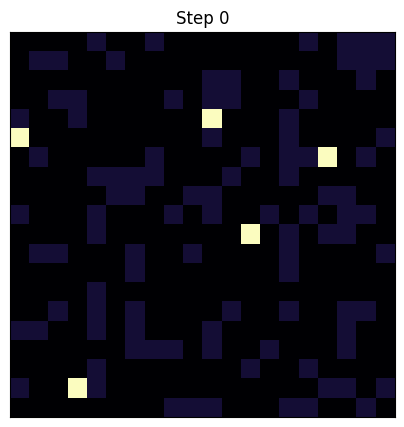

In [47]:
fig, axs = plt.subplots(figsize=(5, 5))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grids.iloc[0,0], cmap=plt.cm.magma)

grids_data = [all_grids.iloc[i, 0] for i in range(len(all_grids))]

def animate(i):
    patch.set_data(grids_data[i])
    axs.set_title(f"Step {i}")
    return patch,


anim = animation.FuncAnimation(fig, animate, frames=range(len(all_grids)), repeat=False, blit=True)

In [48]:
anim

## Reflexión

El análisis de las gráficas y los resultados obtenidos con la estrategia coordinada muestra una mejora significativa en la eficiencia de los agentes en comparación con la estrategia aleatoria. Los agentes ahora necesitan en promedio menos pasos para llenar una pila, lo que indica que la coordinación y la comunicación entre ellos han reducido considerablemente el tiempo y la energía necesarios para completar la tarea.

La implementación de un sistema de comunicación y mapeo compartido ha permitido a los agentes tomar decisiones más informadas sobre sus movimientos, eliminando gran parte del movimiento aleatorio que anteriormente consumía mucho tiempo. Este enfoque colaborativo ha resultado en una distribución más equilibrada del trabajo entre los agentes, lo que ha mejorado la escalabilidad del sistema.

Sin embargo, aún hay espacio para mejoras. Por ejemplo, se podría optimizar aún más la estrategia de búsqueda de paquetes y pilas, implementando algoritmos más avanzados de planificación de rutas. Además, se podría explorar la posibilidad de ajustar dinámicamente la energía y los tiempos de recarga de los agentes en función de su desempeño y las condiciones del entorno.

En resumen, la estrategia coordinada ha demostrado ser una mejora significativa sobre la estrategia aleatoria, pero aún hay oportunidades para seguir optimizando el sistema y mejorar aún más la eficiencia de los agentes.